In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

# Define parameters & Libraries

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from datasets import load_dataset

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import numpy as np

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
latent_dim = 128
learning_rate = 1e-3
epochs = 50

# Data load using hugging face

In [4]:
hf_dataset = load_dataset("mnist")

def to_tensor_dataset(split):
    images = np.array(hf_dataset[split]['image'])
    images = images.reshape(-1, 28, 28).astype(np.float32) / 255.0
    images = (images - 0.5) / 0.5
    labels = np.array(hf_dataset[split]['label'])

    images_tensor = torch.tensor(images).unsqueeze(1)
    labels_tensor = torch.tensor(labels)

    return TensorDataset(images_tensor, labels_tensor)

train_dataset = to_tensor_dataset("train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Model Build

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

model = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model

In [8]:
model.train()
for epoch in range(epochs):
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        recon, _ = model(data)
        loss = criterion(recon, data.view(data.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/50], Loss: 0.0146
Epoch [2/50], Loss: 0.0144
Epoch [3/50], Loss: 0.0143
Epoch [4/50], Loss: 0.0141
Epoch [5/50], Loss: 0.0139
Epoch [6/50], Loss: 0.0139
Epoch [7/50], Loss: 0.0137
Epoch [8/50], Loss: 0.0136
Epoch [9/50], Loss: 0.0135
Epoch [10/50], Loss: 0.0133
Epoch [11/50], Loss: 0.0133
Epoch [12/50], Loss: 0.0132
Epoch [13/50], Loss: 0.0131
Epoch [14/50], Loss: 0.0130
Epoch [15/50], Loss: 0.0129
Epoch [16/50], Loss: 0.0129
Epoch [17/50], Loss: 0.0128
Epoch [18/50], Loss: 0.0127
Epoch [19/50], Loss: 0.0127
Epoch [20/50], Loss: 0.0126
Epoch [21/50], Loss: 0.0125
Epoch [22/50], Loss: 0.0124
Epoch [23/50], Loss: 0.0124
Epoch [24/50], Loss: 0.0123
Epoch [25/50], Loss: 0.0123
Epoch [26/50], Loss: 0.0122
Epoch [27/50], Loss: 0.0122
Epoch [28/50], Loss: 0.0121
Epoch [29/50], Loss: 0.0121
Epoch [30/50], Loss: 0.0120
Epoch [31/50], Loss: 0.0119
Epoch [32/50], Loss: 0.0119
Epoch [33/50], Loss: 0.0118
Epoch [34/50], Loss: 0.0118
Epoch [35/50], Loss: 0.0118
Epoch [36/50], Loss: 0.0117
E

# Extract embeddings

In [9]:
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        _, embeddings = model(data)
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.append(labels.numpy())

# K-Means Clustering

In [10]:
X = np.vstack(all_embeddings)
y = np.hstack(all_labels)

kmeans = KMeans(n_clusters=10, random_state=42)
preds = kmeans.fit_predict(X)

In [11]:
silhouette = silhouette_score(X, preds)
db_index = davies_bouldin_score(X, preds)
print(f"\nSilhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")


Silhouette Score: 0.044
Davies-Bouldin Index: 2.808


# Visualization using PCA

## 2D plot

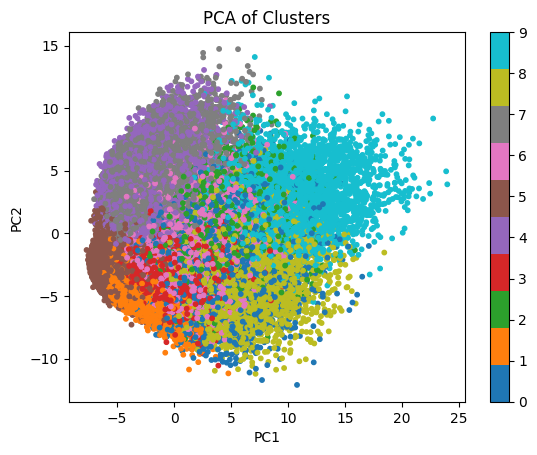

In [18]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=preds, cmap='tab10', s=10)
plt.title("PCA of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

## 3D plot

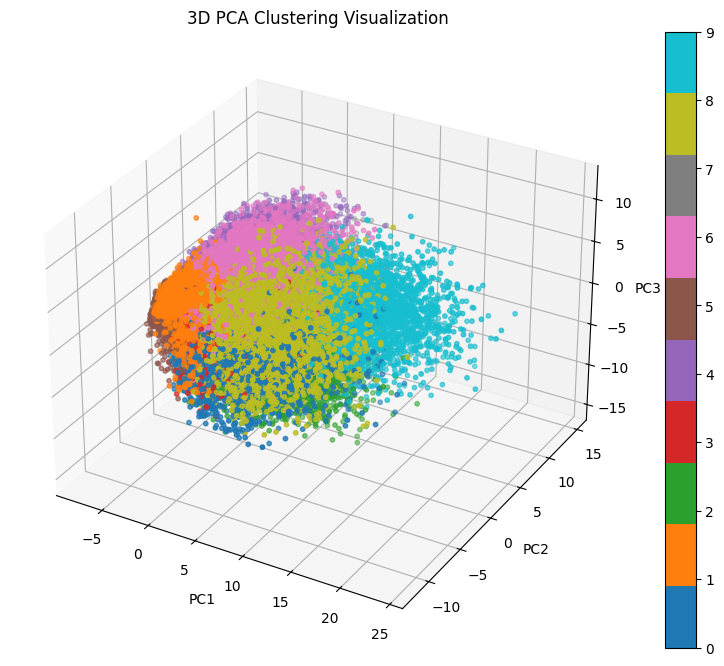

In [19]:
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
                     c=preds, cmap='tab10', s=10)
ax.set_title("3D PCA Clustering Visualization")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
fig.colorbar(scatter)

plt.show()

In [24]:
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)
colors = preds

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=X_3d[:, 0],
    y=X_3d[:, 1],
    z=X_3d[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=colors,
        colorscale='Viridis',  # or 'Jet', 'Plasma', 'Rainbow'
        opacity=0.8,
        colorbar=dict(title="Cluster ID")
    ),
    name='Clustered Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    title='3D PCA Clustering Visualization (K-Means)'
)

fig.show()